# Pipeline to process the dataset

## Calculations - Curvature, Slopes, Reflectance, Color Index, ...

### 1) Imports + detection of spectrum

In [3]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

INPUT_PATH = Path("groups_ana.csv")             
OUT_CSV_PATH = Path("groups_ana_features.csv")
df = pd.read_csv(INPUT_PATH)

w_cols = [c for c in df.columns if re.fullmatch(r"W\d{3,4}", str(c))]
if not w_cols:
    raise ValueError("Not detected.")

wls = np.array([int(c[1:]) for c in w_cols], dtype=int)
order = np.argsort(wls)
wls = wls[order]
w_cols = [w_cols[i] for i in order]
S = df[w_cols].astype(float).to_numpy()
print("Rows:", df.shape[0])
print("Total columns:", df.shape[1])
print("Spectral columns:", len(w_cols), f"({w_cols[0]}..{w_cols[-1]})")
print("λ range:", wls[0], "-", wls[-1], "nm")

Rows: 130
Total columns: 262
Spectral columns: 230 (W300..W1445)
λ range: 300 - 1445 nm


### 2) Definitions: Quadratic interpolation (3 points), slope, curvature, ...

In [5]:
def quad_weights_for_target(wls_nm: np.ndarray, target_nm: float):
    """
    Quadratic interpolation (Lagrange) using 3 points.
    Returns: idx3 (3 indices in wls_nm) and w3 (3 weights) such that:
    R(target) = w0*R(x0) + w1*R(x1) + w2*R(x2)
    """
    wls_nm = np.asarray(wls_nm, dtype=float)
    # 3 puntos más cercanos
    idx = np.argsort(np.abs(wls_nm - target_nm))[:3]
    idx = idx[np.argsort(wls_nm[idx])]  # ordenar por λ
    x0, x1, x2 = wls_nm[idx]
    xt = float(target_nm)
    den0 = (x0 - x1) * (x0 - x2)
    den1 = (x1 - x0) * (x1 - x2)
    den2 = (x2 - x0) * (x2 - x1)
    if den0 == 0 or den1 == 0 or den2 == 0:
        raise ValueError(f"Interpolación degenerada para target={target_nm} con {x0,x1,x2}")
    w0 = (xt - x1) * (xt - x2) / den0
    w1 = (xt - x0) * (xt - x2) / den1
    w2 = (xt - x0) * (xt - x1) / den2
    return idx, np.array([w0, w1, w2], dtype=float)

def interp_quad_all_rows(S: np.ndarray, idx3: np.ndarray, w3: np.ndarray):
    """Interpolation: (N x 3) dot (3,) => (N,)"""
    return S[:, idx3] @ w3

def slope_two_point(Ra, Rb, a_nm: float, b_nm: float):
    """Slope (Rb - Ra)/(b-a)"""
    return (Rb - Ra) / (b_nm - a_nm)

def curvature_quadratic_coeff(R0, R1, R2, x0: float, x1: float, x2: float):
    """
    Coeficient 'a' from p(x)=a x^2 + b x + c, on (x0,R0),(x1,R1),(x2,R2).
    """
    den0 = (x0 - x1) * (x0 - x2)
    den1 = (x1 - x0) * (x1 - x2)
    den2 = (x2 - x0) * (x2 - x1)
    return (R0 / den0) + (R1 / den1) + (R2 / den2)

required_exact = [300, 350, 400, 750, 1445]
missing = [wl for wl in required_exact if f"W{wl}" not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}.")

def lin_weights_for_target(wls_nm: np.ndarray, target_nm: float):
    """
    Lineal interpolation R(target)=w0*R(x0)+w1*R(x1)
    """
    wls_nm = np.asarray(wls_nm, dtype=float)
    t = float(target_nm)

    if t <= wls_nm.min() or t >= wls_nm.max():
        raise ValueError(f"target {t} out of range [{wls_nm.min()}, {wls_nm.max()}]")

    j = np.searchsorted(wls_nm, t)
    i0, i1 = j - 1, j
    x0, x1 = wls_nm[i0], wls_nm[i1]
    if x1 == x0:
        raise ValueError("Repeated points.")

    w1 = (t - x0) / (x1 - x0)
    w0 = 1.0 - w1
    return np.array([i0, i1], dtype=int), np.array([w0, w1], dtype=float)

def interp_lin_all_rows(S: np.ndarray, idx2: np.ndarray, w2: np.ndarray):
    return S[:, idx2] @ w2

def get_R_target(df, S, wls, target_nm: float):
    """
    R(target) to all samples.
    - If W{target} exist.
    - If not, lineal interpolation.
    """
    col = f"W{int(round(target_nm))}"
    if col in df.columns and abs(target_nm - int(round(target_nm))) < 1e-9:
        return df[col].astype(float).to_numpy()

    idx2, w2 = lin_weights_for_target(wls, target_nm)
    return interp_lin_all_rows(S, idx2, w2)

def interp_lin_on_global(global_vec: np.ndarray, wls: np.ndarray, target_nm: float):
    """
    Lineal interpolation of global spectrum (vector).
    """
    idx2, w2 = lin_weights_for_target(wls, target_nm)
    return global_vec[idx2] @ w2

### 3) Slopes + normalization

In [7]:
R300  = df["W300"].astype(float).to_numpy()
R400  = df["W400"].astype(float).to_numpy()
R750  = df["W750"].astype(float).to_numpy()
R1445 = df["W1445"].astype(float).to_numpy()

uv_sl = slope_two_point(R300,  R400,  300,  400)
v_sl  = slope_two_point(R400,  R750,  400,  750)
n_sl  = slope_two_point(R750,  R1445, 750,  1445)
vn_sl = slope_two_point(R400,  R1445, 400,  1445)

wl_to_idx = {wl: i for i, wl in enumerate(wls)}
mR300  = global_mean[wl_to_idx[300]]
mR400  = global_mean[wl_to_idx[400]]
mR750  = global_mean[wl_to_idx[750]]
mR1445 = global_mean[wl_to_idx[1445]]

uv_sl_g = slope_two_point(mR300,  mR400,  300,  400)
v_sl_g  = slope_two_point(mR400,  mR750,  400,  750)
n_sl_g  = slope_two_point(mR750,  mR1445, 750,  1445)
vn_sl_g = slope_two_point(mR400,  mR1445, 400,  1445)

n_uv_sl = uv_sl / uv_sl_g if uv_sl_g != 0 else np.nan
n_v_sl  = v_sl  / v_sl_g  if v_sl_g  != 0 else np.nan
n_n_sl  = n_sl  / n_sl_g  if n_sl_g  != 0 else np.nan
n_vn_sl = vn_sl / vn_sl_g if vn_sl_g != 0 else np.nan

print("Global slopes:", uv_sl_g, v_sl_g, n_sl_g, vn_sl_g)

Global slopes: 8.932371538461537e-05 5.124385714285714e-05 3.316006198118428e-05 3.921683548030916e-05


### 4) Global curvatura + normalization

In [9]:
R350 = df["W350"].astype(float).to_numpy()
curv    = curvature_quadratic_coeff(R300, R750,  R1445, 300, 750, 1445)
uv_curv = curvature_quadratic_coeff(R300, R350,  R400,  300, 350, 400)
mR350 = global_mean[wl_to_idx[350]]
curv_g    = curvature_quadratic_coeff(mR300, mR750, mR1445, 300, 750, 1445)
uv_curv_g = curvature_quadratic_coeff(mR300, mR350, mR400,  300, 350, 400)
n_curv    = curv    / curv_g    if curv_g    != 0 else np.nan
n_uv_curv = uv_curv / uv_curv_g if uv_curv_g != 0 else np.nan
print("Global curv:", curv_g, "Global UV curv:", uv_curv_g)
R450 = get_R_target(df, S, wls, 450.0)
R600 = get_R_target(df, S, wls, 600.0)
curv_300_600 = curvature_quadratic_coeff(R300, R450, R600, 300, 450, 600)
mR450 = interp_lin_on_global(global_mean, wls, 450.0)
mR600 = interp_lin_on_global(global_mean, wls, 600.0)
curv_300_600_g = curvature_quadratic_coeff(mR300, mR450, mR600, 300, 450, 600)
n_curv_300_600 = curv_300_600 / curv_300_600_g if curv_300_600_g != 0 else np.nan
print("Global curv 300-600:", curv_300_600_g)

Global curv: -2.318426714590707e-08 Global UV curv: -7.715769230769078e-08
Global curv 300-600: -6.796329914529917e-08


### 5) uv_down (Goudge et al. 2014) with 3 point interpolation

In [11]:
targets = {
    "R303": 303.0,
    "R324": 324.0,
    "R350": 350.0,   
    "R401": 401.0,
    "R550": 550.0,
    "R750": 750.0,   
}

interp_vals = {}
for name, t in targets.items():
    idx3, w3 = quad_weights_for_target(wls, t)
    interp_vals[name] = interp_quad_all_rows(S, idx3, w3)

R303 = interp_vals["R303"]
R324 = interp_vals["R324"]
R350i = interp_vals["R350"]
R401 = interp_vals["R401"]
R550 = interp_vals["R550"]
R750i = interp_vals["R750"]

VISSlope = (R550 - R750i) / (550.0 - 750.0)
Depth300 = (R401 - (401.0 - 303.0) * VISSlope) / np.where(R303  != 0, R303,  np.nan)
Depth325 = (R401 - (401.0 - 324.0) * VISSlope) / np.where(R324  != 0, R324,  np.nan)
Depth350 = (R401 - (401.0 - 350.0) * VISSlope) / np.where(R350i != 0, R350i, np.nan)
uv_down = Depth300 + Depth325 + Depth350

pd.Series(uv_down).describe()

count    130.000000
mean       3.450323
std        0.265350
min        3.031763
25%        3.238593
50%        3.457614
75%        3.556287
max        4.163395
dtype: float64

### 6) Adding all columns and save to new CSV

In [13]:
new_cols = [
    ("uv_sl", uv_sl),
    ("v_sl",  v_sl),
    ("n_sl",  n_sl),
    ("vn_sl", vn_sl),

    ("n_uv_sl", n_uv_sl),
    ("n_v_sl",  n_v_sl),
    ("n_n_sl",  n_n_sl),
    ("n_vn_sl", n_vn_sl),

    ("curv",      curv),      # curvatura global (300-750-1445)
    ("n_curv",    n_curv),
    ("uv_curv",   uv_curv),   # curvatura UV (300-350-400)
    ("n_uv_curv", n_uv_curv),
    ("curv_300_600", curv_300_600),
    ("n_curv_300_600", n_curv_300_600),
    ("uv_down", uv_down),
]

out = df.copy()
for c, arr in new_cols:
    out[c] = arr

# Reordenar: todo lo original + nuevas al final
new_names = [c for c, _ in new_cols]
orig_cols = [c for c in df.columns if c not in new_names]
out = out[orig_cols + new_names]

out.to_csv(OUT_CSV_PATH, index=False)

print("Saved:", OUT_CSV_PATH.resolve())
print("Saved global spectrum:", OUT_GLOBAL_SPEC_PATH.resolve())
out.head()

Saved: C:\Users\anaoj\Desktop\Citedi\Avances\Articulo RAM\groups_ana_features.csv
Saved global spectrum: C:\Users\anaoj\Desktop\Citedi\Avances\Articulo RAM\global_spectrum_mean_std.csv


,ref_id,id,ci_310_390,ci_415_750,ci_750_415,ci_750_950,obs_id,r310,r390,r750,...,n_v_sl,n_n_sl,n_vn_sl,curv,n_curv,uv_curv,n_uv_curv,curv_300_600,n_curv_300_600,uv_down
0,1125716555401148,8882897,0.699808,0.661759,1.51112,0.783146,orb_11257_165554,0.014945,0.021356,0.033931,...,0.726247,0.706697,0.715253,-1.648841e-08,0.711190,-5.446600e-07,7.059050,-6.849778e-08,1.007864,3.260369
1,1125716555401149,8882898,0.709742,0.655128,1.52642,0.741318,orb_11257_165554,0.013936,0.019635,0.031240,...,0.677377,0.270222,0.448411,-2.492798e-08,1.075211,-2.112000e-07,2.737251,-3.196222e-08,0.470287,3.211813
2,1125716555401150,8882899,0.667963,0.628760,1.59043,0.827315,orb_11257_165554,0.012343,0.018479,0.031044,...,0.715475,0.929049,0.835580,-8.378453e-09,0.361385,-3.743600e-07,4.851882,-5.150667e-08,0.757860,3.221688
3,1125716555401151,8882900,0.696589,0.628122,1.59205,0.813203,orb_11257_165554,0.012484,0.017922,0.029762,...,0.684481,1.359519,1.064092,7.532998e-09,-0.324919,-1.106000e-07,1.433428,-1.948889e-08,0.286756,3.149862
4,1125716555401152,8882901,0.674852,0.617277,1.62002,0.741362,orb_11257_165554,0.011356,0.016827,0.028731,...,0.668473,1.167995,0.949382,8.608561e-10,-0.037131,-3.309600e-07,4.289397,-3.491778e-08,0.513774,3.236620


## Calculations - Absorption Bands

### 7) Re-read CSV with new features y construct matrix

In [16]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
INPUT_PATH = Path("groups_ana_features.csv")
OUT_PATH   = Path("groups_ana_features_bands.csv")
dfb = pd.read_csv(INPUT_PATH)
w_cols = [c for c in dfb.columns if re.fullmatch(r"W\d{3,4}", str(c))]
wls = np.array([int(c[1:]) for c in w_cols], dtype=int)
order = np.argsort(wls)
wls = wls[order]
w_cols = [w_cols[i] for i in order]
S = dfb[w_cols].astype(float).to_numpy()
print("Rows:", dfb.shape[0], "Spectral columns:", len(w_cols), "λ:", wls[0], "-", wls[-1])

Rows: 130 Spectral columns: 230 λ: 300 - 1445


### 8) Definitions

In [18]:
def lin_weights_for_target(wls_nm: np.ndarray, target_nm: float):
    wls_nm = np.asarray(wls_nm, dtype=float)
    t = float(target_nm)
    if t <= wls_nm.min() or t >= wls_nm.max():
        raise ValueError(f"target {t} fuera de rango [{wls_nm.min()}, {wls_nm.max()}]")
    j = np.searchsorted(wls_nm, t)
    i0, i1 = j - 1, j
    x0, x1 = wls_nm[i0], wls_nm[i1]
    if x1 == x0:
        raise ValueError("Puntos repetidos para interpolación lineal.")
    w1 = (t - x0) / (x1 - x0)
    w0 = 1.0 - w1
    return np.array([i0, i1], dtype=int), np.array([w0, w1], dtype=float)

def interp_lin_all_rows(M: np.ndarray, idx2: np.ndarray, w2: np.ndarray):
    return M[:, idx2] @ w2

def get_R_target(df, S, wls, target_nm: float):
    if abs(target_nm - int(round(target_nm))) < 1e-9:
        col = f"W{int(target_nm)}"
        if col in df.columns:
            return df[col].astype(float).to_numpy()
    idx2, w2 = lin_weights_for_target(wls, target_nm)
    return interp_lin_all_rows(S, idx2, w2)

### 9) Band depth + presence (adding features and cleaning features)

In [20]:
from pathlib import Path

bands = [
    ("bd_pyrox_sulf_588_750_828", [0.588, 0.750, 0.828], 0.01),
    ("bd_pyrox_sulf_528_750_828", [0.528, 0.750, 0.828], 0.01),
    ("bd_mgs_cas_559_629_749",    [0.559, 0.629, 0.749], 0.01),
    ("bd_fe2_1000_1050_1200",     [1.000, 1.050, 1.200], 0.01),
]

UNC = 0.01 

def band_depth_type2(L, C, R):
    avg = (L + R) / 2.0
    return (avg - C) / np.where(avg != 0, avg, np.nan)

def band_sigma_type2(depth, L, C, R, UNC):
    denom = (L + R)
    p1 = (UNC**2 + UNC**2) / np.where(denom != 0, denom**2, np.nan)
    e1 = np.where(C != 0, UNC / C, 0.0)
    return depth * np.sqrt(p1 + e1**2)

for key, triplet_um, thresh in bands:
    triplet_nm = [v * 1000.0 for v in triplet_um]  # µm -> nm
    L = get_R_target(dfb, S, wls, triplet_nm[0])
    C = get_R_target(dfb, S, wls, triplet_nm[1])
    R = get_R_target(dfb, S, wls, triplet_nm[2])
    depth = band_depth_type2(L, C, R)
    pres = ((depth > thresh) & np.isfinite(depth)).astype(int)
    sigma = band_sigma_type2(depth, L, C, R, UNC)
    dfb[f"{key}_depth"] = depth
    dfb[f"{key}_pres"]  = pres
    dfb[f"{key}_sigma"] = sigma

OUT_PATH = Path("groups_ana_features_bands.csv")
dfb.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH.resolve())

new_tail_cols = [c for c in dfb.columns if c.endswith("_depth") or c.endswith("_pres") or c.endswith("_sigma")]
dfb[new_tail_cols].head()

Saved: C:\Users\anaoj\Desktop\Citedi\Avances\Articulo RAM\groups_ana_features_bands.csv


,bd_pyrox_sulf_588_750_828_depth,bd_pyrox_sulf_588_750_828_pres,bd_pyrox_sulf_588_750_828_sigma,bd_pyrox_sulf_528_750_828_depth,bd_pyrox_sulf_528_750_828_pres,bd_pyrox_sulf_528_750_828_sigma,bd_mgs_cas_559_629_749_depth,bd_mgs_cas_559_629_749_pres,bd_mgs_cas_559_629_749_sigma,bd_fe2_1000_1050_1200_depth,bd_fe2_1000_1050_1200_pres,bd_fe2_1000_1050_1200_sigma
0,-0.076711,0,-0.028446,-0.105888,0,-0.039660,0.028253,1,0.011415,0.100936,1,0.031531
1,-0.002512,0,-0.000986,-0.032582,0,-0.012921,0.024808,1,0.010859,0.131568,1,0.043534
2,-0.148198,0,-0.061615,-0.185068,0,-0.077935,0.039866,1,0.018036,0.132739,1,0.044925
3,-0.018006,0,-0.007466,-0.049499,0,-0.020742,0.030517,1,0.014299,-0.011136,0,-0.003508
4,-0.093357,0,-0.041114,-0.127556,0,-0.056839,0.032595,1,0.015885,0.071380,1,0.025101


In [35]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

DATA_FILE = Path("groups_ana_features_bands.csv")
IND_FILE  = Path("MineralesCaract_IndicatorsRange.xlsx")
OUT_FILE  = Path("groups_ana_features_bands_indicators.csv")

df = pd.read_csv(DATA_FILE)

w_cols = [c for c in df.columns if re.fullmatch(r"W\d{3,4}", str(c))]
if not w_cols:
    raise ValueError("No Wxxx columns detected in groups_ana_features_bands.csv")

wls = np.array([int(c[1:]) for c in w_cols], dtype=float)
ordr = np.argsort(wls)
wls = wls[ordr]
w_cols = [w_cols[i] for i in ordr]
S = df[w_cols].astype(float).to_numpy()
N = S.shape[0]

wl_min, wl_max = float(wls.min()), float(wls.max())
print("Mercury λ range (nm):", wl_min, "-", wl_max)

def find_col(df0, candidates):
    lc_map = {c.lower(): c for c in df0.columns}
    for cand in candidates:
        if cand.lower() in lc_map:
            return lc_map[cand.lower()]
    for c in df0.columns:
        cl = c.lower()
        for cand in candidates:
            if cand.lower() in cl:
                return c
    return None

interp_cache = {}
smooth_cache = {}

def interp_R_all(target_nm: float) -> np.ndarray:
    t = float(target_nm)
    if t in interp_cache:
        return interp_cache[t]
    ti = int(round(t))
    if abs(t - ti) < 1e-12:
        col = f"W{ti}"
        if col in df.columns:
            y = df[col].astype(float).to_numpy()
            interp_cache[t] = y
            return y
    if t <= wl_min or t >= wl_max:
        y = np.full(N, np.nan, dtype=float)
        interp_cache[t] = y
        return y
    j = np.searchsorted(wls, t)
    i0, i1 = j - 1, j
    x0, x1 = wls[i0], wls[i1]
    w1 = (t - x0) / (x1 - x0)
    w0 = 1.0 - w1
    y = S[:, i0] * w0 + S[:, i1] * w1
    interp_cache[t] = y
    return y

def smooth3_interp_um(w_target_um: float) -> np.ndarray:
    """
    Local 3-point average around target (µm) using linear interpolation at:
      target-step, target, target+step
    step = 0.025 µm (<1.05 µm) else 0.05 µm
    """
    w_target_nm = float(w_target_um) * 1000.0
    if w_target_nm in smooth_cache:
        return smooth_cache[w_target_nm]

    step_nm = 25.0 if w_target_nm < 1050.0 else 50.0
    w_left  = max(w_target_nm - step_nm, wl_min)
    w_right = min(w_target_nm + step_nm, wl_max)

    R_c = interp_R_all(w_target_nm)
    R_l = interp_R_all(w_left)
    R_r = interp_R_all(w_right)

    y = (R_l + R_c + R_r) / 3.0
    smooth_cache[w_target_nm] = y
    return y

def in_range_um(vals_um):
    """True if all wavelengths (µm) are within [wl_min, wl_max] in nm."""
    vals_nm = np.array(vals_um, dtype=float) * 1000.0
    return np.all(vals_nm >= wl_min) and np.all(vals_nm <= wl_max)

# --------------------
# Read Excel indicators
# Need at least: Subclass, Type, Indicator. Min/TolMin optional.
# --------------------
df_ind = pd.read_excel(IND_FILE)

col_sub  = find_col(df_ind, ["subclass", "sub-class", "sub_class"])
col_type = find_col(df_ind, ["type"])
col_ind  = find_col(df_ind, ["indicator", "name"])
col_min  = find_col(df_ind, ["min", "d_min"])
col_tol  = find_col(df_ind, ["tolmin", "tol_min", "tolerance", "tol"])

need = {"Subclass": col_sub, "Type": col_type, "Indicator": col_ind}
missing = [k for k, v in need.items() if v is None]
if missing:
    raise ValueError(f"Missing required columns in Excel: {missing}. Found: {list(df_ind.columns)}")

if col_min is not None:
    df_ind[col_min] = pd.to_numeric(df_ind[col_min], errors="coerce")
else:
    df_ind["__Min__"] = np.nan
    col_min = "__Min__"

if col_tol is not None:
    df_ind[col_tol] = pd.to_numeric(df_ind[col_tol], errors="coerce")
else:
    df_ind["__TolMin__"] = 0.0
    col_tol = "__TolMin__"

# --------------------
# Parse indicator names
# Slope...:      Slope0.450_0.780 or SlopeVIS0.450_0.780 (µm)
# BandDepth...:  BandDepth0.945_1.020_0.980 (b1,b2,bc) in µm
# --------------------
def parse_nums_after(prefix: str, name: str, n: int):
    s = str(name).strip()
    if not s.startswith(prefix):
        return None
    body = s[len(prefix):]
    m = re.search(r"[-\d\.].*$", body)
    if not m:
        return None
    parts = m.group(0).split("_")
    if len(parts) < n:
        return None
    try:
        return [float(parts[i]) for i in range(n)]
    except Exception:
        return None

# --------------------
# 1) Add Slope indicators (ONLY if in-range)
# slope per µm
# --------------------
df_slope = df_ind[df_ind[col_type].astype(str).str.lower().eq("slope")].drop_duplicates(subset=[col_ind]).copy()

added_slopes = 0
skipped_slopes = 0

for _, row in df_slope.iterrows():
    ind_name = str(row[col_ind]).strip()
    parsed = parse_nums_after("Slope", ind_name, 2)
    if parsed is None:
        continue
    w1_um, w2_um = parsed
    if not in_range_um([w1_um, w2_um]):
        skipped_slopes += 1
        continue
    if w2_um == w1_um:
        skipped_slopes += 1
        continue

    R1 = smooth3_interp_um(w1_um)
    R2 = smooth3_interp_um(w2_um)
    df[ind_name] = (R2 - R1) / (w2_um - w1_um)
    added_slopes += 1

print(f"✅ Slopes added: {added_slopes} | skipped out-of-range: {skipped_slopes}")

# --------------------
# 2) Add BandDepth indicators + present flag (ONLY if in-range)
# depth = ((avg(L,R) - C) / avg(L,R)), clipped to >=0
# presence threshold: lower = max(D_min - TolMin, 0)
# If D_min is NaN => we compute depth but skip present flag (all NaN)
# --------------------
df_bd = df_ind[df_ind[col_type].astype(str).str.lower().eq("banddepth")].copy()
unique_bd = sorted({str(x).strip() for x in df_bd[col_ind].dropna().unique()})

added_bd = 0
skipped_bd = 0

# For thresholds: take the minimum Min and maximum TolMin per indicator (as your prior pattern)
cfg_bd = (
    df_bd.groupby(col_ind, as_index=False)
         .agg(D_min=(col_min, "min"),
              TolMin=(col_tol, "max"))
)
cfg_map = {str(r[col_ind]).strip(): (r["D_min"], r["TolMin"]) for _, r in cfg_bd.iterrows()}

for ind_name in unique_bd:
    parsed = parse_nums_after("BandDepth", ind_name, 3)
    if parsed is None:
        continue
    b1_um, b2_um, bc_um = parsed

    if not in_range_um([b1_um, b2_um, bc_um]):
        skipped_bd += 1
        continue

    R1 = smooth3_interp_um(b1_um)
    R2 = smooth3_interp_um(b2_um)
    Rc = smooth3_interp_um(bc_um)

    AVG = (R1 + R2) / 2.0
    denom = np.where(AVG != 0, AVG, np.nan)

    depth = (AVG - Rc) / denom
    depth = np.where(np.isfinite(depth), depth, 0.0)
    depth = np.clip(depth, 0.0, None)

    df[ind_name] = depth

    D_min, TolMin = cfg_map.get(ind_name, (np.nan, 0.0))
    if pd.isna(D_min):
        df[ind_name + "_present"] = np.nan
    else:
        lower = max(float(D_min) - (0.0 if pd.isna(TolMin) else float(TolMin)), 0.0)
        EPS = 1e-12
        df[ind_name + "_present"] = ((depth > EPS) & (depth >= lower)).astype(int)

    added_bd += 1

print(f"✅ BandDepth added: {added_bd} | skipped out-of-range: {skipped_bd}")

# --------------------
# 3) bd_yn_<subclass> computed at SUBCLASS level (Excel-defined),
# skipping out-of-range indicators (i.e., those we did NOT compute).
#
# For each subclass:
#   collect its BandDepth indicators from Excel
#   keep only those that exist in df (computed, thus in-range)
#   subclass is 1 if for ALL kept indicators: global presence == 1
#   global presence is computed as: max(present over all spectra)
#   If none kept -> bd_yn = 0 (conservative)
# --------------------
def sanitize_col(s: str) -> str:
    s = str(s).strip().lower()
    s = re.sub(r"[^a-z0-9]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s if s else "unknown"

# Build subclass -> list of banddepth indicator names (from Excel)
bd_rows = df_ind[df_ind[col_type].astype(str).str.lower().eq("banddepth")].copy()
sub_to_inds = (
    bd_rows.groupby(col_sub)[col_ind]
           .apply(lambda x: [str(v).strip() for v in x.dropna().tolist()])
           .to_dict()
)

created = 0
for sub, inds in sub_to_inds.items():
    col_out = f"bd_yn_{sanitize_col(sub)}"

    # Keep only in-range/computed banddepth indicators
    usable = [ind for ind in inds if ind in df.columns and (ind + "_present") in df.columns]

    if len(usable) == 0:
        df[col_out] = 0
        created += 1
        continue

    # For each indicator, decide if it is present somewhere in the dataset
    # (Subclass-level, since Mercury file has no subclass per row)
    ok_list = []
    for ind in usable:
        pres = df[ind + "_present"].to_numpy()
    
        # Conservative: NaN / inf -> 0 (not present)
        pres = np.where(np.isfinite(pres), pres, 0).astype(int)
    
        # Strict global presence: must be 1 for ALL spectra
        ok_list.append(np.all(pres == 1))
    
    df[col_out] = int(all(ok_list))
    created += 1

print(f"✅ Created bd_yn_* subclass columns (constants): {created}")
df.to_csv(OUT_FILE, index=False)
print("Saved:", OUT_FILE.resolve())

Mercury λ range (nm): 300.0 - 1445.0
✅ Slopes added: 0 | skipped out-of-range: 0
✅ BandDepth added: 75 | skipped out-of-range: 0
✅ Created bd_yn_* subclass columns (constants): 63
Saved: C:\Users\anaoj\Desktop\Citedi\Avances\Articulo RAM\groups_ana_features_bands_indicators.csv


C:\Users\anaoj\AppData\Local\Temp\ipykernel_2040\711775235.py:250: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ind_name + "_present"] = ((depth > EPS) & (depth >= lower)).astype(int)
C:\Users\anaoj\AppData\Local\Temp\ipykernel_2040\711775235.py:242: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ind_name] = depth
C:\Users\anaoj\AppData\Local\Temp\ipykernel_2040\711775235.py:250: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

In [37]:
# ============================================================
# CLEAN OUTPUT: drop Slope*, drop bd_yn_*==0 and related BandDepth cols, rename bd_yn_* with triplets
# Input : groups_ana_features_bands_indicators.csv
# Excel : MineralesCaract_IndicatorsRange.xlsx
# Output: groups_ana_features_bands_indicators_clean.csv
# ============================================================

import pandas as pd
import numpy as np
import re
from pathlib import Path

IN_FILE  = Path("groups_ana_features_bands_indicators.csv")
IND_FILE = Path("MineralesCaract_IndicatorsRange.xlsx")
OUT_FILE = Path("groups_ana_features_bands_indicators_clean.csv")

# --- Columns you said MUST NOT be touched (keep always) ---
PROTECTED = set([
    "bd_pyrox_sulf_588_750_828_depth","bd_pyrox_sulf_588_750_828_pres","bd_pyrox_sulf_588_750_828_sigma",
    "bd_pyrox_sulf_528_750_828_depth","bd_pyrox_sulf_528_750_828_pres","bd_pyrox_sulf_528_750_828_sigma",
    "bd_mgs_cas_559_629_749_depth","bd_mgs_cas_559_629_749_pres","bd_mgs_cas_559_629_749_sigma",
    "bd_fe2_1000_1050_1200_depth","bd_fe2_1000_1050_1200_pres","bd_fe2_1000_1050_1200_sigma",
])

df = pd.read_csv(IN_FILE)
df_ind = pd.read_excel(IND_FILE)

def find_col(df0, candidates):
    lc_map = {c.lower(): c for c in df0.columns}
    for cand in candidates:
        if cand.lower() in lc_map:
            return lc_map[cand.lower()]
    for c in df0.columns:
        cl = c.lower()
        for cand in candidates:
            if cand.lower() in cl:
                return c
    return None

col_sub  = find_col(df_ind, ["subclass", "sub-class", "sub_class"])
col_type = find_col(df_ind, ["type"])
col_ind  = find_col(df_ind, ["indicator", "name"])
if col_sub is None or col_type is None or col_ind is None:
    raise ValueError(f"Excel must have Subclass/Type/Indicator columns. Found: {list(df_ind.columns)}")

def sanitize_col(s: str) -> str:
    s = str(s).strip().lower()
    s = re.sub(r"[^a-z0-9]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s if s else "unknown"

# --------------------
# 1) Drop ALL Slope* columns (prefix)
# --------------------
slope_cols = [c for c in df.columns if str(c).startswith("Slope")]
df = df.drop(columns=slope_cols, errors="ignore")

print(f"✅ Dropped Slope* columns: {len(slope_cols)}")

# --------------------
# 2) Build mapping: subclass -> BandDepth indicators from Excel
# --------------------
df_bd = df_ind[df_ind[col_type].astype(str).str.lower().eq("banddepth")].copy()

sub_to_inds = (
    df_bd.groupby(col_sub)[col_ind]
         .apply(lambda x: [str(v).strip() for v in x.dropna().tolist()])
         .to_dict()
)

# --------------------
# 3) Identify which bd_yn_* columns exist and which are 0 vs 1
# --------------------
bdyn_cols = [c for c in df.columns if str(c).startswith("bd_yn_")]

keep_bdyn = []
drop_bdyn = []
for c in bdyn_cols:
    # assume constant column (or almost): use max (works even if repeated)
    v = pd.to_numeric(df[c], errors="coerce")
    m = int(np.nanmax(v.to_numpy())) if np.isfinite(np.nanmax(v.to_numpy())) else 0
    if m == 1:
        keep_bdyn.append(c)
    else:
        drop_bdyn.append(c)

print(f"✅ bd_yn_* keep (==1): {len(keep_bdyn)} | drop (==0): {len(drop_bdyn)}")

# Drop bd_yn_* == 0
df = df.drop(columns=drop_bdyn, errors="ignore")

# --------------------
# 4) Drop "related columns" for removed subclasses:
#    - related = BandDepth indicator column + its _present
#    - BUT only drop if NOT needed by any kept subclass
#    - AND never drop PROTECTED columns
# --------------------
# Determine kept/removed subclasses by matching sanitized subclass names to bd_yn columns
kept_sub_san = set([c[len("bd_yn_"):] for c in keep_bdyn])
dropped_sub_san = set([c[len("bd_yn_"):] for c in drop_bdyn])

# Map sanitized subclass -> indicator list
san_to_inds = {sanitize_col(sub): inds for sub, inds in sub_to_inds.items()}

# Indicators needed by kept subclasses
needed_inds = set()
for sub_san in kept_sub_san:
    for ind in san_to_inds.get(sub_san, []):
        needed_inds.add(ind)

# Indicators eligible to drop (from removed subclasses) but not needed by kept subclasses
drop_inds = set()
for sub_san in dropped_sub_san:
    for ind in san_to_inds.get(sub_san, []):
        if ind not in needed_inds:
            drop_inds.add(ind)

# Build concrete column list to drop: ind and ind_present
drop_cols = set()
for ind in drop_inds:
    drop_cols.add(ind)
    drop_cols.add(ind + "_present")

# Remove protected columns from drop list
drop_cols = [c for c in drop_cols if c in df.columns and c not in PROTECTED]

df = df.drop(columns=drop_cols, errors="ignore")
print(f"✅ Dropped related BandDepth columns (exclusive to removed subclasses): {len(drop_cols)}")

# --------------------
# 5) Rename remaining bd_yn_* columns to append BandDepth triplets used in that subclass
#    Example: bd_yn_zoisite__1.385_1.425_1.405__0.9_1.0_0.95
# --------------------
def banddepth_triplet_suffix(ind_name: str):
    s = str(ind_name).strip()
    if not s.startswith("BandDepth"):
        return None
    body = s[len("BandDepth"):]
    m = re.search(r"[-\d\.].*$", body)
    if not m:
        return None
    # keep the underscore-separated triplet string
    return m.group(0)

rename_map = {}
used_names = set(df.columns)

for c in keep_bdyn:
    sub_san = c[len("bd_yn_"):]
    inds = san_to_inds.get(sub_san, [])

    # Only consider indicators that actually exist in df (computed/in-range)
    usable = [ind for ind in inds if ind in df.columns and (ind + "_present") in df.columns]

    triplets = []
    for ind in usable:
        t = banddepth_triplet_suffix(ind)
        if t is not None:
            triplets.append(t)

    # Build new name
    if len(triplets) == 0:
        new_name = c
    else:
        suffix = "__" + "__".join(triplets)
        new_name = c + suffix

    # Ensure uniqueness
    base = new_name
    k = 2
    while new_name in used_names:
        new_name = f"{base}_{k}"
        k += 1

    if new_name != c:
        rename_map[c] = new_name
        used_names.add(new_name)

df = df.rename(columns=rename_map)
print(f"✅ Renamed bd_yn_* kept columns: {len(rename_map)}")
df.to_csv(OUT_FILE, index=False)
print("Saved:", OUT_FILE.resolve())

✅ Dropped Slope* columns: 0
✅ bd_yn_* keep (==1): 1 | drop (==0): 62
✅ Dropped related BandDepth columns (exclusive to removed subclasses): 148
✅ Renamed bd_yn_* kept columns: 1
Saved: C:\Users\anaoj\Desktop\Citedi\Avances\Articulo RAM\groups_ana_features_bands_indicators_clean.csv


### 10) Calculation of Variance on each metric to compare with PowerBI - Skip this step

In [19]:
import pandas as pd
import numpy as np

df = pd.read_csv("groups_ana_features_bands_indicators_clean.csv")

excluded = {"ref_id", "id", "obs_id"}

metric_cols = [
    c for c in df.columns
    if (
        (
            c.startswith("W") or
            (c.startswith("r") and c not in excluded) or
            c.startswith("BandDepth") or
            c.startswith("bd_") or
            c.startswith("ci_") or
            c in [
                "n_v_sl",
                "n_n_sl",
                "n_vn_sl",
                "n_uv_sl",
                "n_curv",
                "n_uv_curv",
                "n_curv_300_600"
            ]
        )
        and not c.endswith("pres")
        and not c.endswith("present")
    )
]

metric_cols = sorted(set(metric_cols))

df_long = df.melt(
    id_vars=["group_title"],
    value_vars=metric_cols,
    var_name="metric",
    value_name="value"
).dropna(subset=["value"])

stats = (
    df_long
    .groupby(["group_title", "metric"])
    .agg(
        mean=("value", np.mean),
        variance=("value", np.var),
        std=("value", np.std),
        n=("value", "count")
    )
    .reset_index()
)

stats["cv"] = stats["std"] / stats["mean"]

def metric_type(m):
    if m.startswith("W"):
        return "Wavelength"
    if m.startswith("r"):
        return "Reflectance"
    if "sl" in m:
        return "Slope"
    if "curv" in m:
        return "Curvature"
    if m.startswith("ci_"):
        return "Color Index"
    if m.startswith("BandDepth") or m.startswith("bd_"):
        return "Band Depth"
    return "Other"

stats["metric_type"] = stats["metric"].apply(metric_type)

table_metrics = stats.sort_values("variance", ascending=False)

table_metric_type = (
    stats
    .groupby("metric_type")
    .agg(
        variance_sum=("variance", "sum"),
        variance_mean=("variance", "mean"),
        metric_count=("metric", "nunique")
    )
    .reset_index()
    .sort_values("variance_sum", ascending=False)
)

table_submetric = (
    stats
    .groupby("metric")
    .agg(
        variance_sum=("variance", "sum"),
        variance_mean=("variance", "mean"),
        group_count=("group_title", "nunique")
    )
    .reset_index()
    .sort_values("variance_sum", ascending=False)
)

table_metrics.to_csv("table_1_stats.csv", index=False)
table_metric_type.to_csv("table_2_variance_by_metric.csv", index=False)
table_submetric.to_csv("table_3_variance_by_submetric.csv", index=False)
table_metrics, table_metric_type, table_submetric

C:\Users\anaoj\AppData\Local\Temp\ipykernel_43980\2687497932.py:44: FutureWarning: The provided callable <function mean at 0x0000017C678A1EE0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg(
C:\Users\anaoj\AppData\Local\Temp\ipykernel_43980\2687497932.py:44: FutureWarning: The provided callable <function var at 0x0000017C678A2160> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  .agg(
C:\Users\anaoj\AppData\Local\Temp\ipykernel_43980\2687497932.py:44: FutureWarning: The provided callable <function std at 0x0000017C678A2020> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  .agg(


(              group_title                             metric      mean  \
 1045     lrm_rachmaninoff                          n_uv_curv  1.900699   
 247      hollows_eminescu                          n_uv_curv  4.646381   
 513   hrp_westofrustaveli                          n_uv_curv  1.038728   
 779      lbp_westofmakeba                          n_uv_curv -0.532680   
 245      hollows_eminescu                     n_curv_300_600  5.768979   
 ...                   ...                                ...       ...   
 234      hollows_eminescu       bd_mgs_cas_559_629_749_sigma  0.001157   
 505   hrp_westofrustaveli  bd_yn_ilmenite__0.450_0.900_0.500  1.000000   
 239      hollows_eminescu  bd_yn_ilmenite__0.450_0.900_0.500  1.000000   
 771      lbp_westofmakeba  bd_yn_ilmenite__0.450_0.900_0.500  1.000000   
 1037     lrm_rachmaninoff  bd_yn_ilmenite__0.450_0.900_0.500  1.000000   
 
           variance       std   n        cv metric_type  
 1045  3.800111e+00  1.949387  28  1.025

## Calculations - Principal Component Analysis

PC1 explained variance: 91.02%
PC2 explained variance: 5.78%


,PC1_loading,PC2_loading,abs_PC1,abs_PC2,total_contribution
ci_750_415,-0.021166,0.223895,0.021166,0.223895,0.245061
ci_415_750,0.028563,-0.213667,0.028563,0.213667,0.242230
n_vn_sl,0.025434,0.214128,0.025434,0.214128,0.239562
n_n_sl,0.004312,0.204088,0.004312,0.204088,0.208400
uv_down,0.040064,-0.153898,0.040064,0.153898,0.193963
ci_750_950,0.015564,-0.172294,0.015564,0.172294,0.187859
n_v_sl,0.053395,0.125084,0.053395,0.125084,0.178480
n_curv_300_600,0.057286,-0.115984,0.057286,0.115984,0.173270
W1415,0.056494,0.102516,0.056494,0.102516,0.159010
W1365,0.058396,0.096000,0.058396,0.096000,0.154396


C:\Users\anaoj\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\anaoj\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


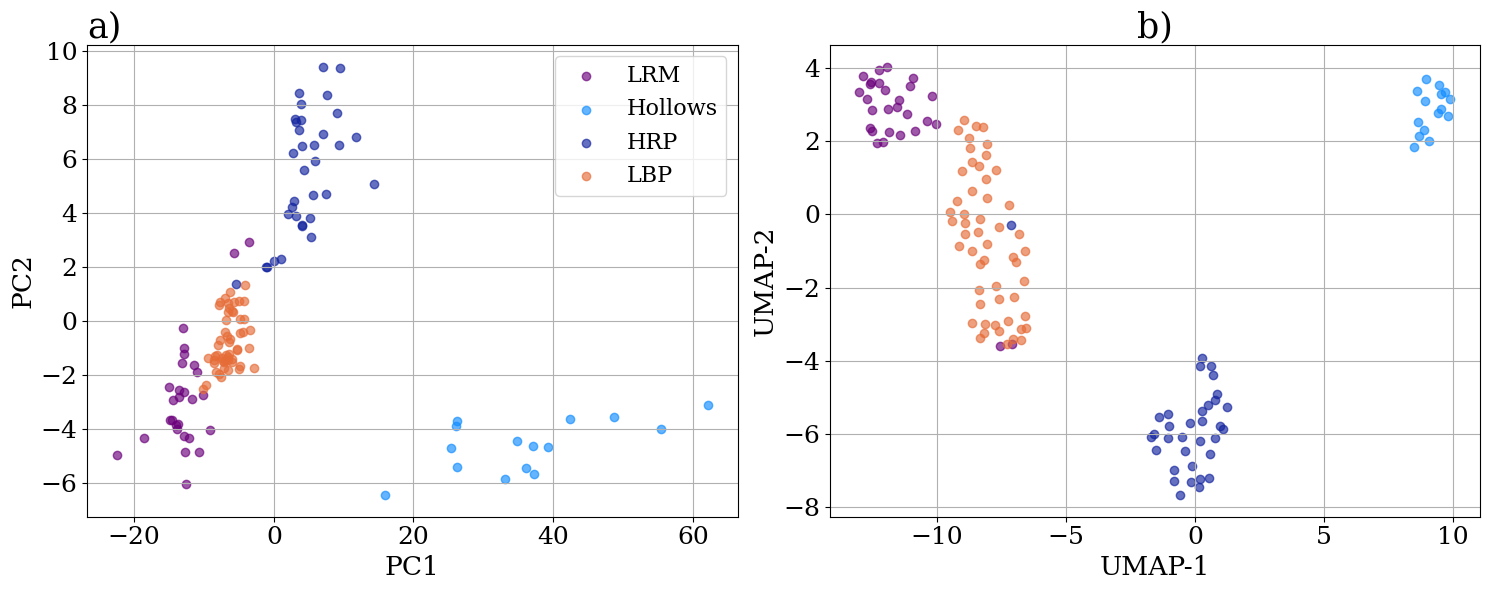

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from IPython.display import display

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Serif"],
    "axes.titlesize": 25,
    "axes.labelsize": 30,
    "legend.fontsize": 16,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

df = pd.read_csv("groups_ana_features_bands_indicators_clean.csv")

excluded = {"ref_id", "id", "obs_id", }

group_colors = {
    "hollows_eminescu": "#118DFF",
    "lrm_rachmaninoff": "#6B007B",
    "hrp_westofrustaveli": "#12239E",
    "lbp_westofmakeba": "#E66C37"
}

group_labels = {
    "hollows_eminescu": "Hollows",   
    "lrm_rachmaninoff": "LRM",
    "hrp_westofrustaveli": "HRP",
    "lbp_westofmakeba": "LBP"
}

metric_cols = [
    c for c in df.columns
    if (
        (
            c.startswith("W") or
            (c.startswith("r") and c not in excluded) or
            c.startswith("ci_") or
            c in [
                "n_v_sl",
                "n_n_sl",
                "n_vn_sl",
                "n_uv_sl",
                "n_curv",
                "n_uv_curv",
                "n_curv_300_600",
                "uv_down"
            ]
        )
        and not c.endswith("pres")
        and not c.endswith("present")
        and not c.startswith("BandDepth")
        and not c.startswith("bd_")
    )
]

metric_cols = sorted(set(metric_cols))

X = df[metric_cols].dropna()
groups = df.loc[X.index, "group_title"]

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100

print(f"PC1 explained variance: {pc1_var:.2f}%")
print(f"PC2 explained variance: {pc2_var:.2f}%")


loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1_loading", "PC2_loading"],
    index=metric_cols
)

loadings["abs_PC1"] = loadings["PC1_loading"].abs()
loadings["abs_PC2"] = loadings["PC2_loading"].abs()
loadings["total_contribution"] = loadings["abs_PC1"] + loadings["abs_PC2"]

loadings_sorted = loadings.sort_values(
    by="total_contribution",
    ascending=False
)

loadings_top20 = loadings_sorted.head(20)
display(loadings_top20)

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.5,
    n_components=2,
    random_state=42
)
X_umap = umap_model.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=False, sharey=False)

for g in groups.unique():
    idx = groups == g
    axes[0].scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        label=group_labels.get(g, g), 
        color=group_colors.get(g, "gray"),
        alpha=0.65
    )

axes[0].set_title("a)", loc='left')
axes[0].set_xlabel("PC1", fontsize=19)
axes[0].set_ylabel("PC2", fontsize=19)
axes[0].grid(True)
axes[0].legend(loc="best", frameon=True)

for g in groups.unique():
    idx = groups == g
    axes[1].scatter(
        X_umap[idx, 0],
        X_umap[idx, 1],
        label=group_labels.get(g, g), 
        color=group_colors.get(g, "gray"),
        alpha=0.65
    )

axes[1].set_title("b)")
axes[1].set_xlabel("UMAP-1", fontsize=19)
axes[1].set_ylabel("UMAP-2", fontsize=19)
axes[1].grid(True)
#axes[1].legend(loc="best", frameon=True)

plt.tight_layout()
plt.show()

## References

In [ ]:
print("\n References")
print("[1] Barraud et al. (2020). https://doi.org/10.1029/2020JE006497")
print("[2] Besse et al. (2015). https://doi.org/10.1002/2015JE004819")
print("[3] Caminiti et al. (2023). https://doi.org/10.1029/2022JE007685")
print("[4] Izenberg et al. (2014). https://doi.org/10.1016/j.icarus.2013.10.023")
print("[5] Lucchetti et al. (2018). https://doi.org/10.1029/2018JE005722")
print("[6] Sprague et al. (2007). https://doi.org/10.1007/s11214-007-9221-3")
print("[7] Vilas et al. (2016). https://doi.org/10.1002/2015GL067515")